In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from LogicalQ.Logical import LogicalCircuit, LogicalStatevector
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Library.Targets import construct_target_generic_iontrap
from LogicalQ.NoiseModel import construct_noise_model_QuantinuumH2_1
from LogicalQ.Experiments import execute_circuits
from LogicalQ.Analysis import calculate_exp_val

In [3]:
noise_model = None#construct_noise_model_QuantinuumH2_1(n_qubits=32)

In [4]:
qec_cycle_count_list = [0, 1, 2, 4, 8, 16, 32, 64]
lqc_list = []

In [5]:
lqc_base = LogicalCircuit(1, **steane_code)
lqc_base.encode([0])
lqc_base.measure_all()

lqc_list.append(lqc_base)

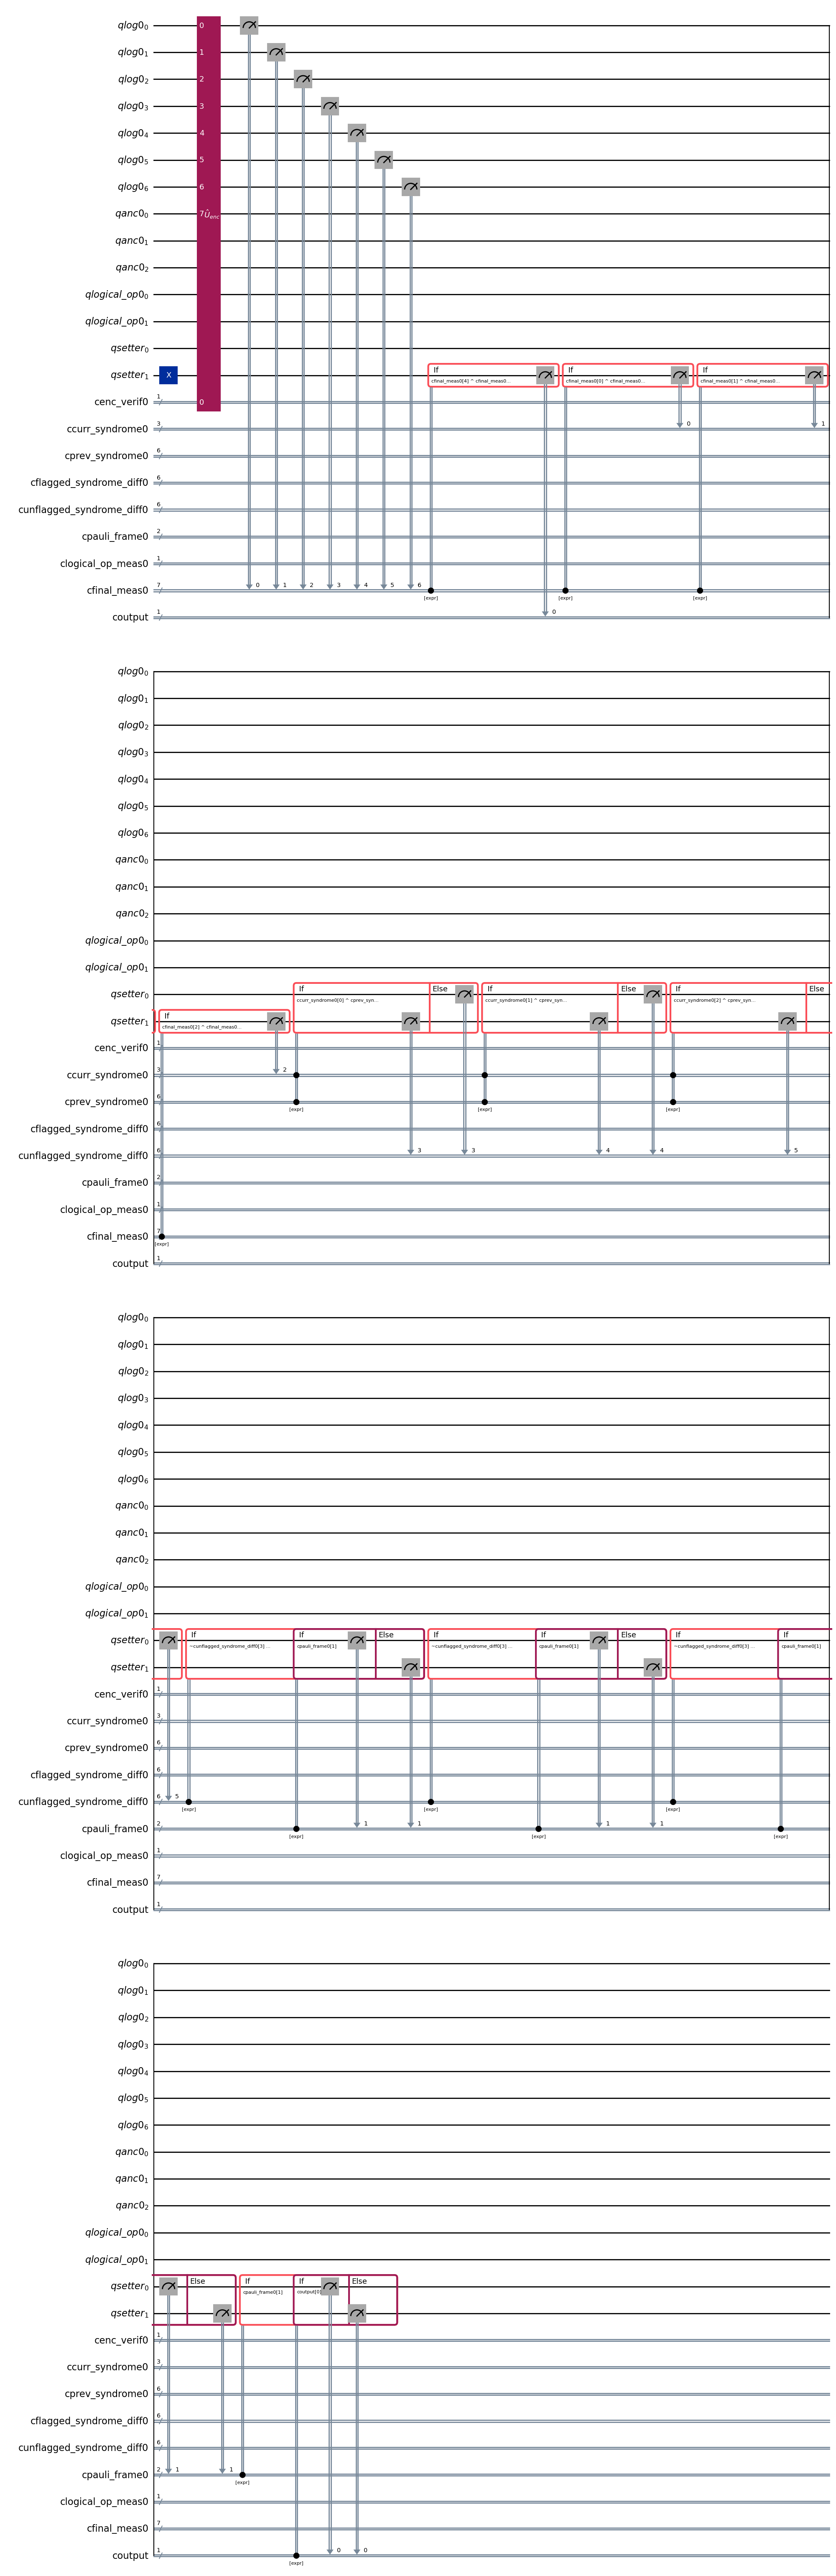

In [6]:
data = []
for n_qec_cycles in qec_cycle_count_list[1:]:
    lqc = copy.deepcopy(lqc_base)
    for _ in range(n_qec_cycles):
        lqc.append_qec_cycle()
    lqc.measure_all()
    lqc_list.append(lqc)

lqc_list[0].draw("mpl")

In [7]:
results = execute_circuits(lqc_list, backend="aer_simulator", noise_model=noise_model, method="statevector", shots=16384, memory=True)

In [8]:
lqc_list[0].get_logical_output_counts(results[0].get_counts())

{'0': 8}

In [9]:
results[0].get_counts()

{'0 1010101 0 00 000000 000000 000000 000 0': 2013,
 '0 0000000 0 00 000000 000000 000000 000 0': 2083,
 '0 1100011 0 00 000000 000000 000000 000 0': 2025,
 '0 1101100 0 00 000000 000000 000000 000 0': 2071,
 '0 1011010 0 00 000000 000000 000000 000 0': 2047,
 '0 0111001 0 00 000000 000000 000000 000 0': 1982,
 '0 0001111 0 00 000000 000000 000000 000 0': 2072,
 '0 0110110 0 00 000000 000000 000000 000 0': 2091}

In [10]:
lsv_list = []
for result in results:
    lsv = LogicalStatevector.from_counts(result.get_counts(), n_logical_qubits=1, **steane_code)
    print(lsv[0])

    lsv_list.append(lsv)

(0.3565616783513758+0j)
(0.3540701035278351+0j)
(0.3548449355955465+0j)
(0.3528144529285874+0j)
(0.3503538259234492+0j)
(0.3519577771111756+0j)
(0.3574619652409882+0j)
(0.3540863055958229+0j)


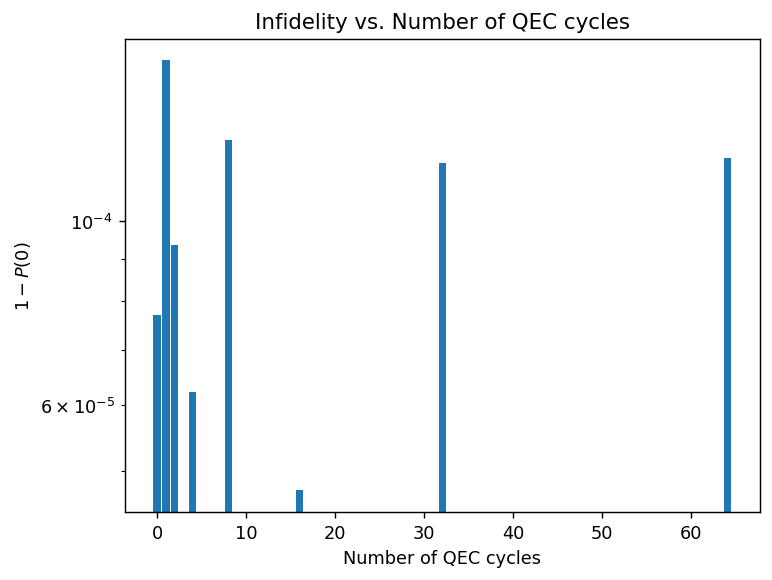

In [31]:
fig, ax = plt.subplots(dpi=128)

qec_cycle_count_list = [0,1,2,4,8,16,32,64]
exp_vals = [1-lsv.logical_decomposition[0]**2 for lsv in lsv_list]

ax.bar(qec_cycle_count_list, exp_vals)

ax.set_title("Infidelity vs. Number of QEC cycles")
ax.set_xlabel("Number of QEC cycles")
ax.set_ylabel(r"$1 - P(0)$")
ax.set_yscale("log")

plt.show()